In [2]:
from generate_lib import *
from types import NoneType

In [3]:
SHOW_PLOTS = True
SAVE_PLOTS = False

In [4]:
ALIGNED = 0
RANDOM = 1

def get_prob_avgs(filenames):
    assert type(filenames) == list

    MAX_PLANETS = 9

    sums = dict()
    nums = dict()
    avgs = dict()

    sums[ALIGNED] = dict()
    sums[RANDOM] = dict()
    nums[ALIGNED] = dict()
    nums[RANDOM] = dict()
    avgs[ALIGNED] = dict()
    avgs[RANDOM] = dict()
    
    time = np.array([])

    suffix = '_randomO'

    failed_systems = []
    sucessful_systems = []

    for filename in filenames:
        filepath = os.path.join(path, filename)

        (header, data) = csv_2_data(filepath)

        time_col = header.index('Time')

        end_time = float(data[time_col][-1])

        if end_time < 1e6:
            failed_systems.append(filename)

            continue
        else:
            sucessful_systems.append(filename)

        if len(time) == 0:
            time = data[time_col].astype(float)

        for n in range(MAX_PLANETS + 1):
            head = n_planet_prob(n)
            
            if head not in header:
                continue

            key = [ALIGNED, RANDOM][(suffix in filename)]
            col = header.index(head)

            prob = clean_data(data[col].astype(float))

            if head not in sums[key]:
                sums[key][head] = prob
                nums[key][head] = 1
            else:
                sums[key][head] += prob
                nums[key][head] += 1

            assert sums.keys() == nums.keys()

    num_failed = len(failed_systems)
    num_succeeded = len(sucessful_systems)
    pct_failed = (num_failed / (num_failed + num_succeeded)) * 100.0

    output = '''SYSTEMS:
    # failed: {failed}
    # succeeded: {succ}
    % failed: {pct}%
    '''.format(failed = num_failed, succ = num_succeeded, pct = pct_failed)

    print(output)

    for key in sums:
        for head in sums[key]:
            avgs[key][head] = (sums[key][head] / nums[key][head])

    return (time, avgs)

In [6]:
'''def save_data(savename):
    if '.csv' not in savename:
        savename += '.csv'

    savepath = os.path.join(os.pardir, 'results', 'sum-exp-values', savename)

    data = sums['aligned']
    rdata = sums['random']
    tdata = aligned_data[0]['axes']['x']

    output = [tdata]

    keys = sorted(data.keys())

    for key in keys:
        output.append(data[key])

    for key in keys:
        output.append(rdata[key])

    output = list(np.array(output).T)

    with open(savepath, 'w', encoding = 'utf-8') as file:
        header = 'Time,'

        for key in keys:
            n = int(key)
            
            header += n_planet_prob(n) + ' (Aligned Omega),'

        for key in keys:
            n = int(key)
            
            header += n_planet_prob(n) + ' (Random Omega),'

        header += '\n'

        file.write(header)

        for idx in range(len(output)):
            line = ''
            
            for idx2 in range(len(output[idx])):
                line += str(output[idx][idx2]) + ','

            line += '\n'

            file.write(line)

save_data('sum-exp-values.csv')'''

"def save_data(savename):\n    if '.csv' not in savename:\n        savename += '.csv'\n\n    savepath = os.path.join(os.pardir, 'results', 'sum-exp-values', savename)\n\n    data = sums['aligned']\n    rdata = sums['random']\n    tdata = aligned_data[0]['axes']['x']\n\n    output = [tdata]\n\n    keys = sorted(data.keys())\n\n    for key in keys:\n        output.append(data[key])\n\n    for key in keys:\n        output.append(rdata[key])\n\n    output = list(np.array(output).T)\n\n    with open(savepath, 'w', encoding = 'utf-8') as file:\n        header = 'Time,'\n\n        for key in keys:\n            n = int(key)\n            \n            header += n_planet_prob(n) + ' (Aligned Omega),'\n\n        for key in keys:\n            n = int(key)\n            \n            header += n_planet_prob(n) + ' (Random Omega),'\n\n        header += '\n'\n\n        file.write(header)\n\n        for idx in range(len(output)):\n            line = ''\n            \n            for idx2 in range(len(o

SYSTEMS:
    # failed: 78
    # succeeded: 122
    % failed: 39.0%
    


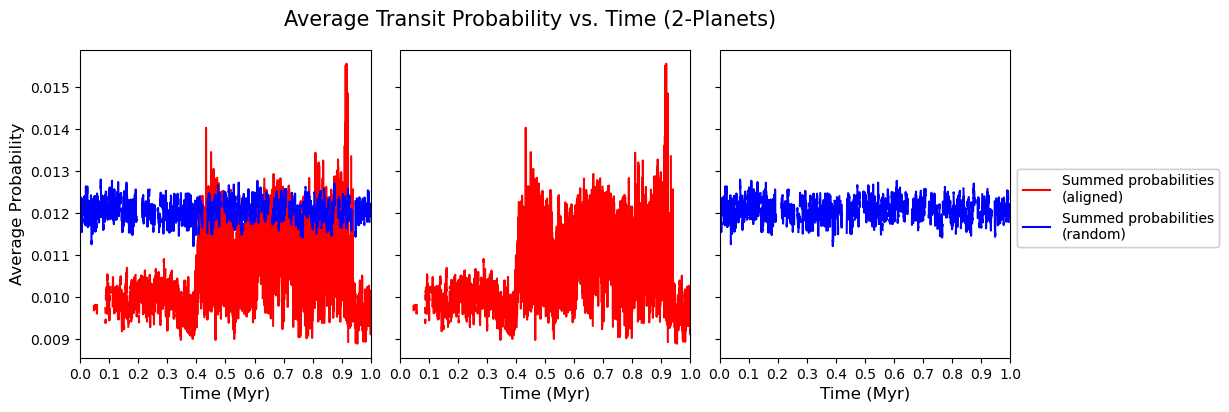

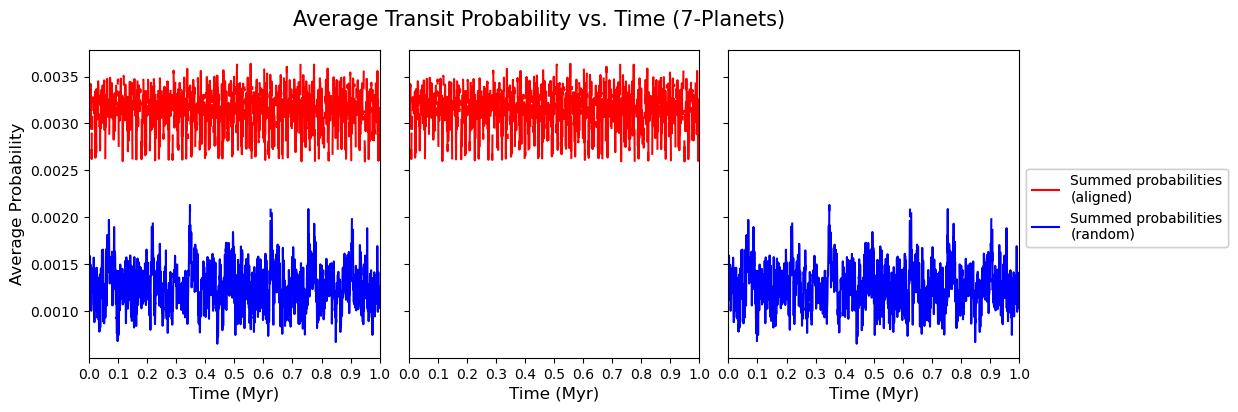

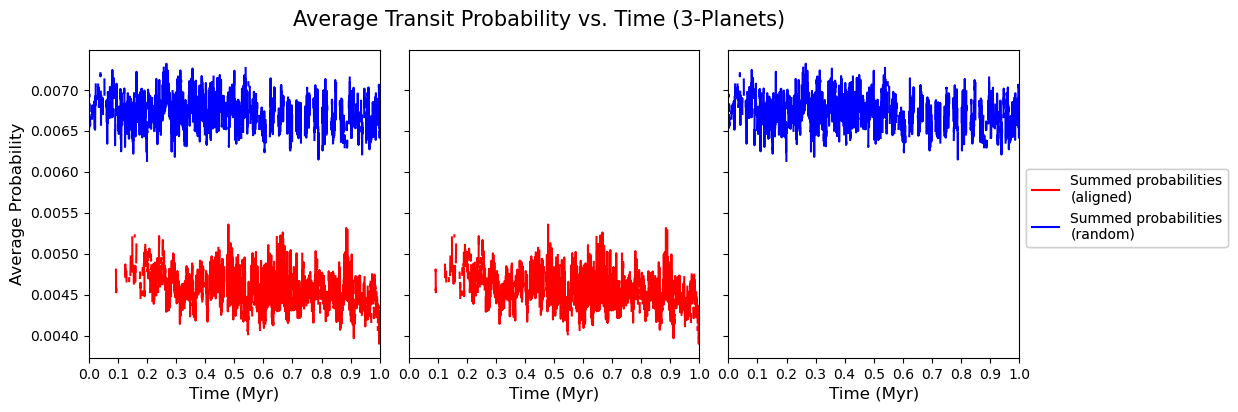

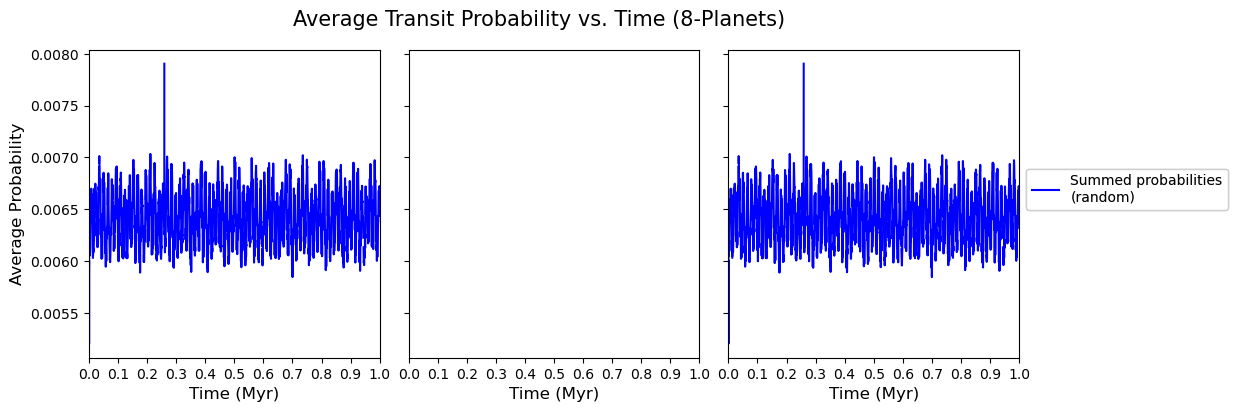

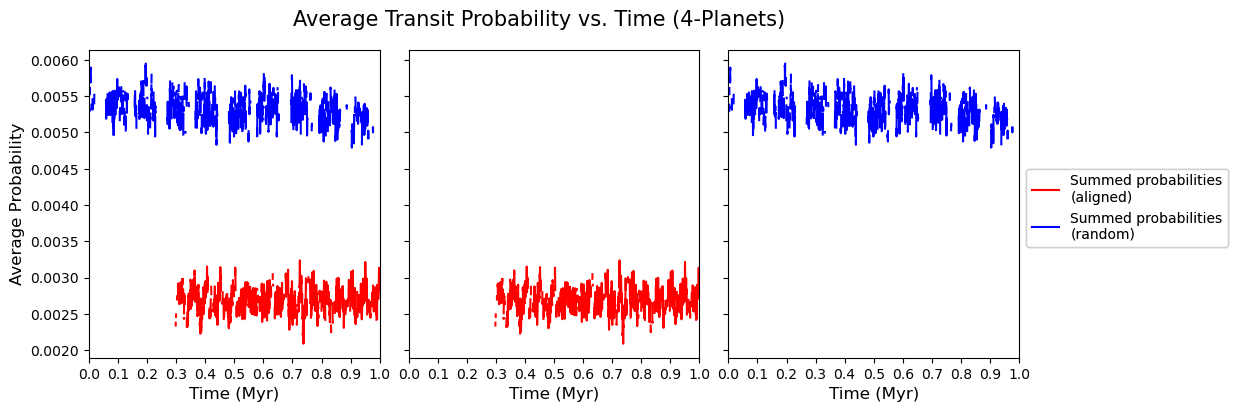

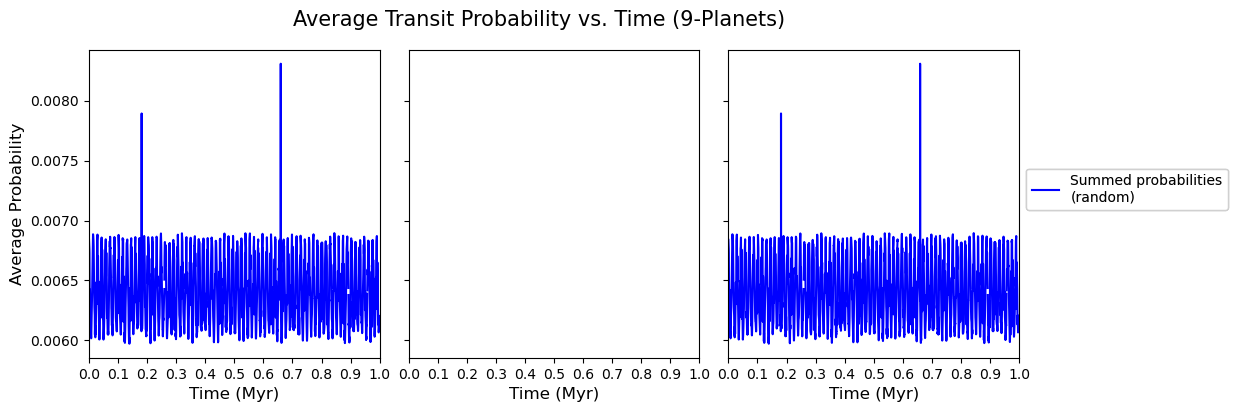

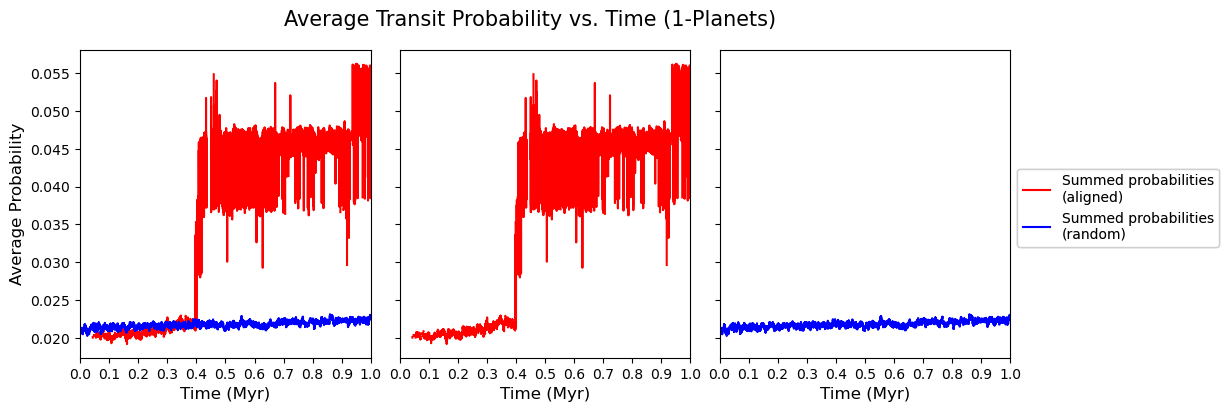

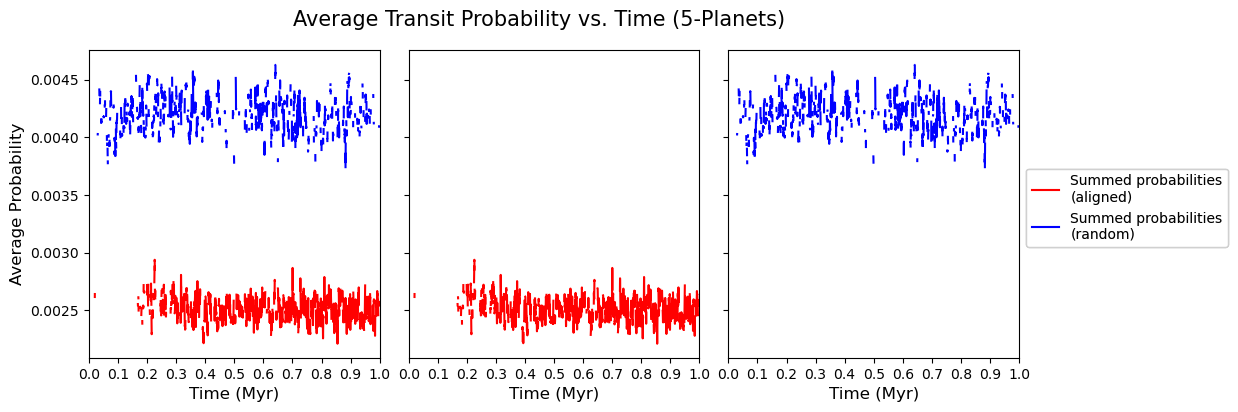

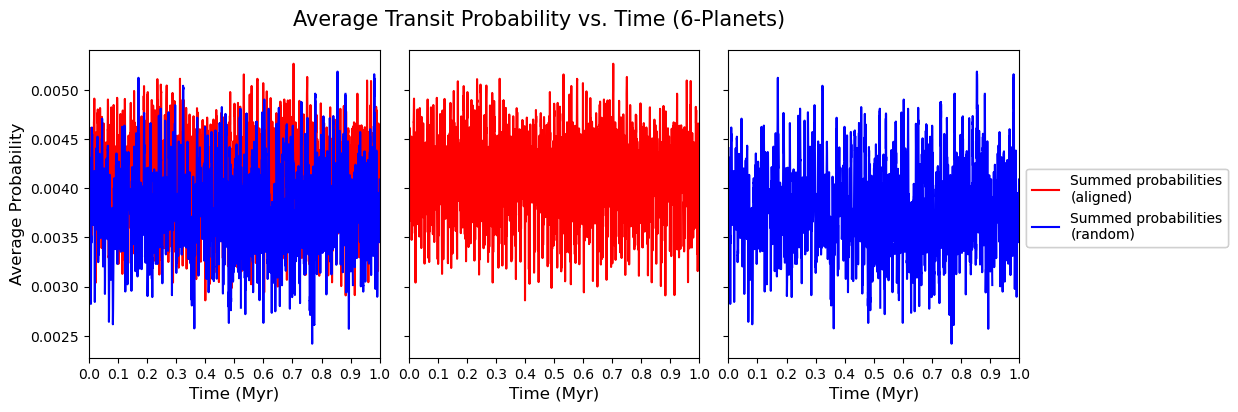

In [7]:
(time, avgs) = get_prob_avgs(data_files[0:200])

heads = set(list(avgs[RANDOM].keys()) + list(avgs[ALIGNED].keys()))

for head in heads:
    (fig, axes) = plt.subplots(1, 3, sharey = True)
    fig.set_size_inches(12, 4)

    (x, y) = (time, avgs[ALIGNED][head]) if head in avgs[ALIGNED] else (None, None)
    (rx, ry) = (time, avgs[RANDOM][head]) if head in avgs[RANDOM] else (None, None)

    plt.subplot(1, 3, 1)

    if type(y) != NoneType:
        plt.plot(x, y, color = 'red', label = 'Summed probabilities\n(aligned)')
    
    if type(ry) != NoneType:
        plt.plot(rx, ry, color = 'blue', label = 'Summed probabilities\n(random)')

    plt.subplot(1, 3, 2)
    
    if type(y) != NoneType:
        plt.plot(x, y, color = 'red')

    plt.subplot(1, 3, 3)
    
    if type(ry) != NoneType:
        plt.plot(rx, ry, color = 'blue')

    for col in range(len(axes)):
        ax = axes[col]

        if col == 0:
            ax.set_ylabel('Average Probability', fontsize = 12)

        ax.set_xlabel('Time (Myr)', fontsize = 12)
        ax.xaxis.set_major_locator(tck.LinearLocator(11))
        ax.xaxis.set_major_formatter(tck.FuncFormatter(lambda x, pos: '%.1f' % (x/1e6)))

        # Note that this does not calculate the min and max for the random cases, although they should be the same.
        xmin = 0
        xmax = 1e6

        ax.set_xlim(xmin, xmax)    

        fig.suptitle('Average Transit Probability vs. Time ({planets})'.format(planets=head.replace(' ', '-')), fontsize = 15)

        fig.legend(bbox_to_anchor = (0.9, 0.6), loc = 'upper left')
        plt.subplots_adjust(wspace=0.1, hspace=0)

    if SAVE_PLOTS:
        #save_path = os.path.join(os.pardir, 'results', 'sum-exp-values', 'sum-exp-values-{n}-planets'.format(n = key))
        #fig.savefig(save_path, dpi = 300)
        pass

    if SHOW_PLOTS:
        plt.show()